# **Exercise 1: Exploring Movie Recommendation Dataset**
Movielens 100k dataset, Rating prediction dataset (rating scale 1-5).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns
from numpy.random import seed, rand, randn
import math
seed(seed=3116)
import time
from sklearn.decomposition import NMF

In [ ]:
movie_data = pd.read_csv("https://raw.githubusercontent.com/Can-Berk/Machine_Learning_Labs/main/Datasets/ml-100k/u.data",header=None,delimiter="\t")
movie_data.columns = ["user_id", "movie_id", "rating", "timestamp"]

In [ ]:
movie_data.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## *1.) Variety of across users*

In [ ]:
inf = pd.read_table("https://raw.githubusercontent.com/Can-Berk/Machine_Learning_Labs/main/Datasets/ml-100k/u.info", header=None)
inf.head()

,0
0,943 users
1,1682 items
2,100000 ratings


In [ ]:
user_rating_times = movie_data[["user_id","movie_id"]].groupby(["user_id"]).count()
user_rating_times.columns = ["rating_count"]

In [ ]:
user_rating_times.sort_values(["rating_count"], ascending=False).head(5)    #most active users (in terms of rating)

,rating_count
user_id,
405,737
655,685
13,636
450,540
276,518


Text(0, 0.5, 'Count')

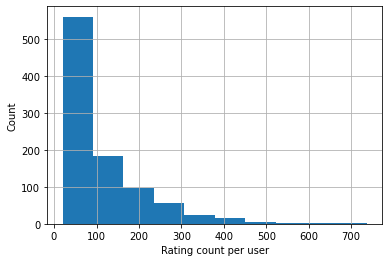

In [ ]:
plt.hist(user_rating_times.rating_count)
plt.grid()
plt.xlabel("Rating count per user")
plt.ylabel("Count")

##### Explanation: Histogram shows that many users participated to rate, however, most of the votes are coming from ~220 of 943 users. Among them around 80 users voted more than 500 times which is significantly higher than rest of the users.

## *2.) Variety of ratings across items*

In [ ]:
item_cols = ['movie_id', 'title', 'release_date' , 'video_release_date', 'IMDb URL',           #item data
           'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
           'Documentary', 'Drama','Fantasy','Film-Noir','Horror','Musical', 
           'Mystery','Romance','Sci-Fi','Thriller','War','Western']
movie_item = pd.read_csv("https://raw.githubusercontent.com/Can-Berk/Machine_Learning_Labs/main/Datasets/ml-100k/u.item", sep='|', names=item_cols, encoding='latin-1')
movie_item.head()

,movie_id,title,release_date,video_release_date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
data_item = pd.merge(movie_data, movie_item, on="movie_id")

In [ ]:
movie_rating_avg = data_item[["title", "rating"]].groupby(["title"]).agg(["mean", "count"])
movie_rating_avg.columns = ["avg_rating","times"]

In [ ]:
movie_rating_avg.sort_values(['avg_rating'], ascending=False)

,avg_rating,times
title,,
They Made Me a Criminal (1939),5.0,1
Marlene Dietrich: Shadow and Light (1996),5.0,1
"Saint of Fort Washington, The (1993)",5.0,2
Someone Else's America (1995),5.0,1
Star Kid (1997),5.0,3
...,...,...
"Eye of Vichy, The (Oeil de Vichy, L') (1993)",1.0,1
King of New York (1990),1.0,1
Touki Bouki (Journey of the Hyena) (1973),1.0,1


In [ ]:
rating_avg = movie_data[["user_id","rating"]].groupby(["user_id"]).mean()
rating_avg.columns = ["rating_count"]
print("average rating of user",round(np.average(rating_avg),4))

average rating of user 3.5882


Text(0, 0.5, 'Count')

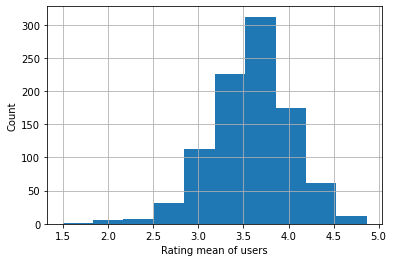

In [ ]:
plt.hist(rating_avg.rating_count)
plt.grid()
plt.xlabel("Rating mean of users")
plt.ylabel("Count")

##### Explanation: Average rating of movies are shown in the table with the given number of votes. Ratings vary from 1-bad to 5-perfect. We see most of the extreme points are based on few votes, while average rating of all users is 3.5882. Therefore, it would be better to filter movies for at least 10 number of votes. In the table, we can see "Star Kid" movie can be considered more reliable option. 

## *3.) Genres that are more highly rated than others*

In [ ]:
data_item.columns

Index(['user_id', 'movie_id', 'rating', 'timestamp', 'title', 'release_date',
       'video_release_date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')

In [ ]:
df = data_item.drop(["user_id","movie_id","rating","timestamp","title","release_date","video_release_date","IMDb URL"],axis=1)

In [ ]:
df

,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
99996,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
99997,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
99998,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
genre_rated_times = df.sum().sort_values(ascending=False)
print(genre_rated_times)

Drama          39895
Comedy         29832
Action         25589
Thriller       21872
Romance        19461
Adventure      13753
Sci-Fi         12730
War             9398
Crime           8055
Children        7182
Horror          5317
Mystery         5245
Musical         4954
Animation       3605
Western         1854
Film-Noir       1733
Fantasy         1352
Documentary      758
unknown           10
dtype: int64


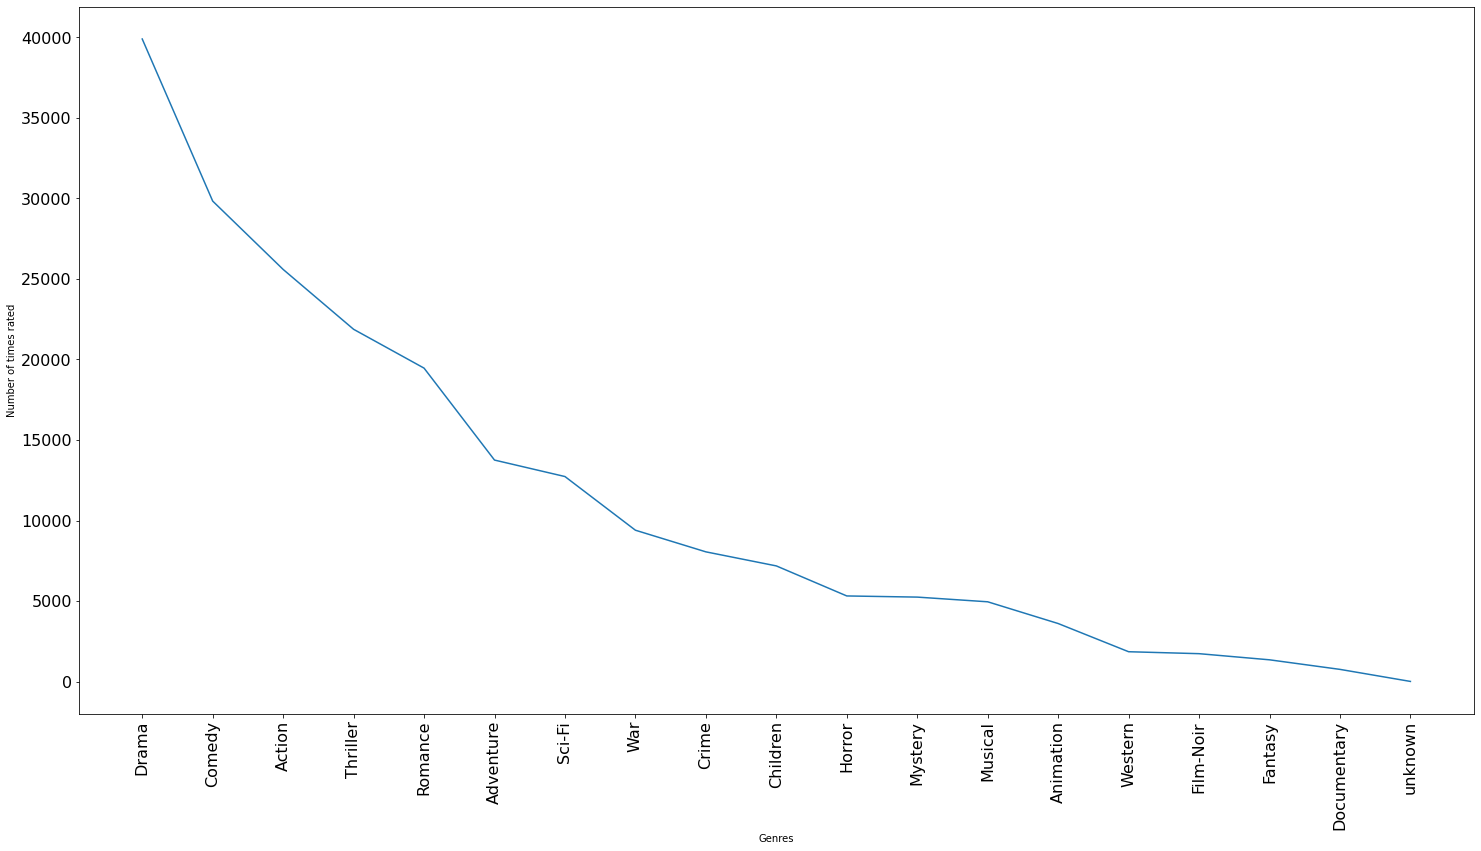

In [ ]:
plt.figure(figsize=(25,13))
plt.plot(genre_rated_times)
plt.ylabel("Number of times rated")
plt.yticks(fontsize=16)
plt.xlabel("Genres")
plt.xticks(rotation='vertical',fontsize=16)
plt.show()

##### Explanation: Looking at the graph, Drama is the most rated genre in the dataset. Followed by comedy and action. Documentery is the least rated genre, while there are not many unknown genre in the dataset.

## 4.) Preferred genres based on ratings of age groups within bins (0-17, 18-23, ... 60+)

In [ ]:
user = pd.read_table("https://raw.githubusercontent.com/Can-Berk/Machine_Learning_Labs/main/Datasets/ml-100k/u.user", engine="python",sep="|", decimal=".", header=None)
user.columns = ["user_id", "age", "gender", "occupation", "zip_code"]
user.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [ ]:
def age_interval(x):
    if x<18:
        b='0-18'
    elif x>=18 and x<24:
        b='18-24'
    elif x>=24 and x<34:
        b='24-34'
    elif x>=34 and x<44:
        b='34-44'
    elif x>=44 and x<54:
        b='44-54'
    elif x>=54 and x<60:
        b='54-60'
    else:
        b='60+'
    return b

In [ ]:
age_intervals=user['age'].apply(age_interval)
user['age_bins'] = age_intervals.values
user.head()

,user_id,age,gender,occupation,zip_code,age_bins
0,1,24,M,technician,85711,24-34
1,2,53,F,other,94043,44-54
2,3,23,M,writer,32067,18-24
3,4,24,M,technician,43537,24-34
4,5,33,F,other,15213,24-34


In [ ]:
data_item = pd.merge(movie_data, movie_item, on="movie_id")
data_item_user = pd.merge(data_item, user, on="user_id")

In [ ]:
data_item_user = data_item_user.drop(["user_id","movie_id","timestamp","title","release_date","video_release_date","IMDb URL","gender","occupation","zip_code","age"],axis=1)

In [ ]:
data_item_user

,rating,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,age_bins
0,3,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,44-54
1,2,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,44-54
2,4,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,44-54
3,4,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,44-54
4,4,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,44-54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,5,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,44-54
99996,4,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,44-54
99997,3,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,44-54
99998,2,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,44-54


In [ ]:
age=data_item_user.groupby("age_bins").sum()
age.reset_index(inplace=True)
age.head()

,age_bins,rating,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0-18,8528,0,733,380,113,267,784,207,13,...,39,34,156,125,138,445,329,618,198,26
1,18-24,67436,2,5602,2807,757,1468,5998,1752,121,...,284,239,1252,868,951,3585,2558,4772,1503,347
2,24-34,135479,6,10241,5543,1564,2797,11914,3039,279,...,529,594,2173,1996,1833,7588,5380,8424,3598,689
3,34-44,66988,2,4679,2694,696,1487,5513,1387,133,...,267,371,944,997,968,3640,2385,3856,1890,388
4,44-54,53226,0,3194,1708,364,853,4054,1178,154,...,172,331,558,672,949,3035,1571,3023,1578,274


In [ ]:
age['Max'] = age[['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
           'Documentary', 'Drama','Fantasy','Film-Noir','Horror','Musical', 
           'Mystery','Romance','Sci-Fi','Thriller','War','Western']].idxmax(axis=1)

In [ ]:
age[['age_bins','Max','Drama']]

,age_bins,Max,Drama
0,0-18,Drama,831
1,18-24,Drama,7015
2,24-34,Drama,14942
3,34-44,Drama,7565
4,44-54,Drama,6785
5,54-60,Drama,1381
6,60+,Drama,1376


##### Explanation: Drama is the most popular genre in the all given age intervals.

# **Exercise 2: Implement a Matrix Factorization (MF) technique for recommender systems**
By implementing Stochastic Gradient Descent (SGD) learning algorithms

### *Normalize the data*

In [ ]:
def normalize(data):           #normalize data func.
    return (data-min(data))/(max(data)-min(data))

In [ ]:
rating_normalized = movie_data[["rating"]].apply(normalize)      #normalize rating column between 0 and 1
movie_data["rating"]=rating_normalized
movie_data=movie_data.iloc[:,:3]
movie_data.head()

,user_id,movie_id,rating
0,196,242,0.50
1,186,302,0.50
2,22,377,0.00
3,244,51,0.25
4,166,346,0.00


In [ ]:
movie_data = movie_data.sample(frac=1,random_state=3116)

### *Split dataset into train (80%), val (10%), test (10%)*

In [ ]:
def train(data,fraction1,fraction2):                 #normalized dataset split into train (80%), val (10%), test (10%)
    n = len(data)
    c=math.ceil((fraction1)*n)
    d=math.ceil((fraction2)*n)
    train = data.iloc[:c,:].reset_index(drop=True)
    return train                                    #Train data

def val(data,fraction1,fraction2):                  #Validation data
    n = len(data)
    c=math.ceil((fraction1)*n)
    d=math.ceil((fraction2)*n)
    val = data.iloc[c:d,:].reset_index(drop=True)
    return val

def test(data,fraction1,fraction2):                 #Test data
    n = len(data)
    c=math.ceil((fraction1)*n)
    d=math.ceil((fraction2)*n)
    test = data.iloc[d:n,:].reset_index(drop=True)
    return test

In [ ]:
train_mov = train(movie_data,0.8,0.9)
val_mov = val(movie_data,0.8,0.9)
test_mov = test(movie_data,0.8,0.9)
print("Train data len:",len(train_mov))
print("Val data len:",len(val_mov))
print("Test data len:",len(test_mov))

Train data len: 80000
Val data len: 10000
Test data len: 10000


In [ ]:
def init_matrix(R,k):                #Rating matrix and latent dimensions to initialize latent matrices P and Q
    P = np.random.random(R.shape[0]*k).reshape(R.shape[0],k)    #random initialization to P and Q between 0 and 1
    Q = np.random.random(R.shape[1]*k).reshape(k,R.shape[1])    
    return P,Q

In [ ]:
inf = pd.read_table("https://raw.githubusercontent.com/Can-Berk/Machine_Learning_Labs/main/Datasets/ml-100k/u.info", header=None)
inf.head()

,0
0,943 users
1,1682 items
2,100000 ratings


In [ ]:
def get_matrix(data):           #get matrix from dataframes
    a=np.array(data)
    row, idx_row = np.unique(a[:,0], return_inverse=True)
    col, idx_col = np.unique(a[:,1], return_inverse=True)
    M = np.zeros((943,1682), dtype = 'int64')   #user ratings for items 0s
    M[idx_row, idx_col] = a[:,2]
    return M

In [ ]:
def mf_sgd(data, K, alpha, lamb, eps, epochs):       #Matrix factorization func. using SGD
    R = get_matrix(data)             #Rating matrix from data
    list_error = []
    P,Q = init_matrix(R,K)           #latent matrices P and Q
    row = np.arange(R.shape[0])
    col = np.arange(R.shape[1])
    np.random.shuffle(row)       #shuffle row and columns
    np.random.shuffle(col)
    
    for i in range(epochs):
        err = 0
        for i in row:
            for j in col:
                if(R[i,j]) > 0:        #in case there is already rating
                    e = R[i,j] - np.matmul(P[i,:], Q[:,j])   #sga
                    for k in range(K):
                        P[i,k] = P[i,k] + alpha*((2*e)*Q[k,j] - 2*lamb*P[i,k])   #update P, Q matrices
                        Q[k,j] = Q[k,j] + alpha*((2*e)*P[i,k] - 2*lamb*Q[k,j])
        for i in row:
            for j in col:
                if(R[i,j]) > 0:
                    err = err + (R[i,j] - np.matmul(P[i,:],Q[:,j]))**2   #calc error
        if err < eps:         #if error is low enough
            factorized_matrix = np.matmul(P,Q)     #get prediction matrix from P, Q matrices
            return list_error, factorized_matrix
        else:                       #if error is not low enough continue learning
            list_error += [err]
    factorized_matrix = np.matmul(P,Q)
    return list_error, factorized_matrix

In [ ]:
def get_RMSE(data,Prediction,N):
    result_sse=0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if(data[i,j]) > 0:
                result_sse = result_sse + ((4*data[i,j]+1) -((4*Prediction[i,j])+1))**2    #sse of normalized ratings
    result_rmse = np.sqrt(result_sse/N)     #calc. ratings rmse
    return result_rmse

### *Optimize the hyper-parameters*

In [ ]:
K=[3,5,10]                                       #grid search for hyperparameters
alpha=[0.01, 0.001]
lamb=[0.1, 0.01]
eps=0.001
epochs=10
k_fold=3
hyperparameter_list = pd.DataFrame(columns=["Latent_Dimensions", "Learning_Rate", "Regularization", "RMSE"])    #init. hyperparameter table

In [ ]:
for k in K:
    for a in alpha:
        for l in lamb:
            final_rmse = 0
            for f in range(k_fold):
                fold_len=int(np.ceil((train_mov.shape[0])/k_fold))      #fold length
                start_idx=f*fold_len                     #index starting point
                index = train_mov.index
                val_idx = index[start_idx:(start_idx+fold_len)]    #index of given fold
                val_fold = train_mov.iloc[val_idx.values,:]
                train_fold = train_mov.drop(val_fold.index)
                error_res, train_fold_prediction=mf_sgd(train_fold,k,a,l,eps,epochs)  #matrix factorization func.
                orig_matrix = get_matrix(val_fold)
                val_rmse = get_RMSE(orig_matrix,train_fold_prediction,val_fold.shape[0])   #fold rmse
                print("val_rmse:", f, "=", round(val_rmse,4))
                final_rmse = final_rmse + (val_rmse/k_fold)        #final rmse as average of fold rmse results
            print("Hyperparameters set: k=", k, "Learning_Rate=", a, "Regularization=", l, "RMSE=", round(final_rmse,4))
            hyperparameter_list = hyperparameter_list.append({"Latent_Dimensions": k, "Learning_Rate": a, "Regularization":l,"RMSE": round(final_rmse,4)}, ignore_index=True)    #hyperparameter list filled

val_rmse: 0 = 0.3609
val_rmse: 1 = 0.3527
val_rmse: 2 = 0.3679
Hyperparameters set: k= 3 Learning_Rate= 0.01 Regularization= 0.1 RMSE= 0.3605
val_rmse: 0 = 0.34
val_rmse: 1 = 0.3059
val_rmse: 2 = 0.3557
Hyperparameters set: k= 3 Learning_Rate= 0.01 Regularization= 0.01 RMSE= 0.3339
val_rmse: 0 = 0.6456
val_rmse: 1 = 0.625
val_rmse: 2 = 0.6652
Hyperparameters set: k= 3 Learning_Rate= 0.001 Regularization= 0.1 RMSE= 0.6452
val_rmse: 0 = 0.6409
val_rmse: 1 = 0.636
val_rmse: 2 = 0.6393
Hyperparameters set: k= 3 Learning_Rate= 0.001 Regularization= 0.01 RMSE= 0.6387
val_rmse: 0 = 0.3363
val_rmse: 1 = 0.3135
val_rmse: 2 = 0.3386
Hyperparameters set: k= 5 Learning_Rate= 0.01 Regularization= 0.1 RMSE= 0.3295
val_rmse: 0 = 0.38
val_rmse: 1 = 0.3387
val_rmse: 2 = 0.3602
Hyperparameters set: k= 5 Learning_Rate= 0.01 Regularization= 0.01 RMSE= 0.3596
val_rmse: 0 = 0.6533
val_rmse: 1 = 0.5913
val_rmse: 2 = 0.6236
Hyperparameters set: k= 5 Learning_Rate= 0.001 Regularization= 0.1 RMSE= 0.6227
val_rm

In [ ]:
hyperparameter_list

,Latent_Dimensions,Learning_Rate,Regularization,RMSE
0,3.0,0.010,0.10,0.3605
1,3.0,0.010,0.01,0.3339
2,3.0,0.001,0.10,0.6452
3,3.0,0.001,0.01,0.6387
4,5.0,0.010,0.10,0.3295
5,5.0,0.010,0.01,0.3596
6,5.0,0.001,0.10,0.6227
7,5.0,0.001,0.01,0.6452
8,10.0,0.010,0.10,0.6281
9,10.0,0.010,0.01,0.7536


In [ ]:
params_best=hyperparameter_list.iloc[np.argmin(hyperparameter_list.RMSE),:]         #find best hyperparameters according to lowest rmse
print("Best hyperparameters:", params_best)

Best hyperparameters: Latent_Dimensions    5.0000
Learning_Rate        0.0100
Regularization       0.1000
RMSE                 0.3295
Name: 4, dtype: float64


### *Compute the test RMSE*

In [ ]:
min_error, best_matrix=mf_sgd(train_mov, int(params_best[0]),params_best[1], params_best[2], eps, epochs)    #train matrix factorization sgd with best hyperparameters
orig_matrix = get_matrix(test_mov)
test_rmse = get_RMSE(orig_matrix,best_matrix,test_mov.shape[0])                    #test it
print("Test data RMSE using best hyperparameters :",round(test_rmse,4))

Test data RMSE using best hyperparameters : 0.3651


# **Exercise 3: Recommender Systems using matrix factorization sckitlearn**
Learn a matrix factorization model using coordinate descent method\
Optimize the hyper parameters and perform a 3-fold cross validation

In [ ]:
K=[3,5,10]                         #grid search for hyperparameters
lamb=[0.1, 0.01, 0.001]
l1 = 0.1    #combination of L1 (more) and L2
eps=0.001
epochs=100
k_fold=3
hyperparameter_list_skl = pd.DataFrame(columns=["Latent_Dimensions", "Regularization", "RMSE"])

In [ ]:
for k in K:
    for lam in lamb:
        final_rmse = 0
        for f in range(k_fold):
            fold_len=int(np.ceil((train_mov.shape[0])/k_fold))
            start_idx=f*fold_len
            index = train_mov.index
            val_idx = index[start_idx:(start_idx+fold_len)]
            val_fold = train_mov.iloc[val_idx.values,:]
            train_fold = train_mov.drop(val_fold.index)
            nmf = NMF(solver="cd", n_components=k, tol=eps, max_iter=epochs, alpha=lam, l1_ratio=l1, init="random", shuffle=True)  #NMF model through sklearn and l1=0.01
            R = get_matrix(train_fold)
            W = nmf.fit_transform(R)    #fit NMF
            H = nmf.components_
            factorized_matrix = np.matmul(W,H)
            orig_matrix = get_matrix(val_fold)
            val_rmse = get_RMSE(orig_matrix,factorized_matrix,val_fold.shape[0])
            print("val_rmse:", f, "=", round(val_rmse,4))
            final_rmse = final_rmse + (val_rmse/k_fold)
        print("Hyperparameters set: k=", k, "l1_ratio=", l1, "Regularization=",lam, "RMSE=",round(final_rmse,4))
        hyperparameter_list_skl = hyperparameter_list_skl.append({"Latent_Dimensions": k, "Regularization":lam, "RMSE": final_rmse}, ignore_index=True)

val_rmse: 0 = 1.7569
val_rmse: 1 = 1.7223
val_rmse: 2 = 1.7669
Hyperparameters set: k= 3 l1_ratio= 0.1 Regularization= 0.1 RMSE= 1.7487
val_rmse: 0 = 1.7545
val_rmse: 1 = 1.7218
val_rmse: 2 = 1.7664
Hyperparameters set: k= 3 l1_ratio= 0.1 Regularization= 0.01 RMSE= 1.7476
val_rmse: 0 = 1.7544
val_rmse: 1 = 1.7224
val_rmse: 2 = 1.7664
Hyperparameters set: k= 3 l1_ratio= 0.1 Regularization= 0.001 RMSE= 1.7477
val_rmse: 0 = 1.7537
val_rmse: 1 = 1.7194
val_rmse: 2 = 1.7631
Hyperparameters set: k= 5 l1_ratio= 0.1 Regularization= 0.1 RMSE= 1.7454
val_rmse: 0 = 1.7528
val_rmse: 1 = 1.7188
val_rmse: 2 = 1.7625
Hyperparameters set: k= 5 l1_ratio= 0.1 Regularization= 0.01 RMSE= 1.7447
val_rmse: 0 = 1.7535
val_rmse: 1 = 1.7185
val_rmse: 2 = 1.7647
Hyperparameters set: k= 5 l1_ratio= 0.1 Regularization= 0.001 RMSE= 1.7456
val_rmse: 0 = 1.7508
val_rmse: 1 = 1.7213
val_rmse: 2 = 1.7608
Hyperparameters set: k= 10 l1_ratio= 0.1 Regularization= 0.1 RMSE= 1.7443
val_rmse: 0 = 1.7504
val_rmse: 1 = 1.7222

In [ ]:
hyperparameter_list_skl

,Latent_Dimensions,Regularization,RMSE
0,3.0,0.100,1.748701
1,3.0,0.010,1.747561
2,3.0,0.001,1.747739
3,5.0,0.100,1.745356
4,5.0,0.010,1.744712
5,5.0,0.001,1.745601
6,10.0,0.100,1.744313
7,10.0,0.010,1.745236
8,10.0,0.001,1.745078


Text(0.5, 0, 'RMSE')

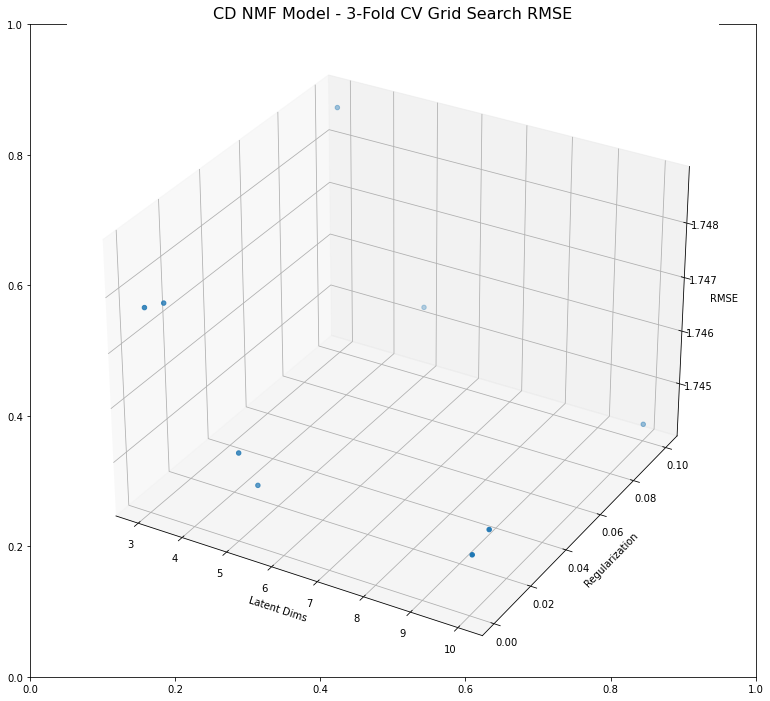

In [ ]:
fig, ax = plt.subplots(figsize=(13, 12))      #Coordinate Descent NMF hyperparameters 3D plot
ax = fig.add_subplot(111, projection="3d")
ax.scatter(hyperparameter_list_skl.Latent_Dimensions, hyperparameter_list_skl.Regularization, hyperparameter_list_skl.RMSE, label='CD NMF')
plt.title("CD NMF Model - 3-Fold CV Grid Search RMSE", fontsize=16)
ax.set_xlabel("Latent Dims")
ax.set_ylabel("Regularization")
ax.set_zlabel("RMSE")

In [ ]:
skl_params_best=hyperparameter_list_skl.iloc[np.argmin(hyperparameter_list_skl.RMSE),:]    #find best hyperparameters according to lowest rmse
print("Best hyperparameters for Coordinate descent using scikitlearn", skl_params_best)

Best hyperparameters for Coordinate descent using scikitlearn Latent_Dimensions    10.000000
Regularization        0.100000
RMSE                  1.744313
Name: 6, dtype: float64


In [ ]:
nmf = NMF(solver="cd", n_components=int(skl_params_best[0]), tol=eps, max_iter=epochs, alpha=skl_params_best[2], l1_ratio=skl_params_best[1],init="random", shuffle=True)    #train matrix factorization sgd with best hyperparameters
R = get_matrix(train_mov)
P = nmf.fit_transform(R);
Q = nmf.components_;
factorized_matrix = np.matmul(P,Q)
orig_matrix = get_matrix(test_mov)
test_rmse = get_RMSE(orig_matrix,factorized_matrix,test_mov.shape[0])                                #test it
print("Coordinate descent with scikitlearn -->  Test data RMSE using best hyperparameters :",round(test_rmse,4))

Coordinate descent with scikitlearn -->  Test data RMSE using best hyperparameters : 1.7912


##### Explanation: Using best hyperparameters for sgd matrix factorization RMSE of 3-fold CV is 0.3295. On test data RMSE is 0.3651. In exercise 3, using built in scikitlearn NMF function to make matrix factorization using Coordinate Descent, it fitted train folds and got matrix W, H to make prediction on ratings. However, its RMSE on test data is 1.7912 which is higher than implemented model. It might be due to CD is not as well suitable as sgd in matrix factorization.

# References
###https://grouplens.org/datasets/movielens/100k/
###https://stackoverflow.com/questions/29919306/find-the-column-name-which-has-the-maximum-value-for-each-row
###https://medium.com/analytics-vidhya/matrix-factorization-as-a-recommender-system-727ee64683f0
###https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html